In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import nltk
import math
import pickle

%matplotlib inline

In [2]:
# Excellent tutorial
# https://towardsdatascience.com/time-series-analysis-with-statsmodels-12309890539a

In [3]:
df = pd.read_csv("hotel_cancellations.csv")

In [4]:
df.head()

,Date_Year_and_Week_Number,IsCanceled
0,201527,41
1,201528,48
2,201529,87
3,201530,74
4,201531,101


In [5]:
df['Date_Year_and_Week_Number'] = df['Date_Year_and_Week_Number'].astype(str)

In [6]:
df.dtypes

Date_Year_and_Week_Number    object
IsCanceled                    int64
dtype: object

In [7]:
# converting the string to datetime format
#df['Date_Year_and_Week_Number'] = pd.to_datetime(df['Date_Year_and_Week_Number'], format='%y%w')
years = []
weeks = []

for yw in df['Date_Year_and_Week_Number']:
    year = yw[0:4]
    week =  yw[4:]
    years.append(year)
    weeks.append(week)

In [8]:
print(years[0:10])
print()
print(weeks[0:10])

['2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015', '2015']

['27', '28', '29', '30', '31', '32', '33', '34', '35', '36']


In [9]:
df['year'] = years

df['week_of_year'] = weeks

In [10]:
df.head()

,Date_Year_and_Week_Number,IsCanceled,year,week_of_year
0,201527,41,2015,27
1,201528,48,2015,28
2,201529,87,2015,29
3,201530,74,2015,30
4,201531,101,2015,31


In [11]:
df.dtypes

Date_Year_and_Week_Number    object
IsCanceled                    int64
year                         object
week_of_year                 object
dtype: object

In [12]:
# code taken from
# https://community.dataiku.com/t5/Using-Dataiku/Converting-week-and-year-to-datetime-stamp-using-Python-function/td-p/11310
# Thanks Jean-Yves
# create date column using week of year and year columns
from datetime import datetime

def process(row):
    year = row["year"]
    week = row["week_of_year"]
    date = "{}-{}-1".format(year, week)
    dt = datetime.strptime(date, "%Y-%W-%w")
    return dt.strftime("%Y-%m-%d")

df['date'] = df.apply(process,axis=1)

In [13]:
df.head()

,Date_Year_and_Week_Number,IsCanceled,year,week_of_year,date
0,201527,41,2015,27,2015-07-06
1,201528,48,2015,28,2015-07-13
2,201529,87,2015,29,2015-07-20
3,201530,74,2015,30,2015-07-27
4,201531,101,2015,31,2015-08-03


In [14]:
df.columns

Index(['Date_Year_and_Week_Number', 'IsCanceled', 'year', 'week_of_year',
       'date'],
      dtype='object')

In [15]:
df.dtypes

Date_Year_and_Week_Number    object
IsCanceled                    int64
year                         object
week_of_year                 object
date                         object
dtype: object

In [16]:
# convert string to datetime object
df['date'] = pd.to_datetime(df['date'])

In [17]:
df.dtypes

Date_Year_and_Week_Number            object
IsCanceled                            int64
year                                 object
week_of_year                         object
date                         datetime64[ns]
dtype: object

In [18]:
#df.set_index('date')

In [19]:
df.tail(10)

,Date_Year_and_Week_Number,IsCanceled,year,week_of_year,date
105,201732,140,2017,32,2017-08-07
106,201733,182,2017,33,2017-08-14
107,201734,143,2017,34,2017-08-21
108,201735,100,2017,35,2017-08-28
109,20174,51,2017,4,2017-01-23
110,20175,51,2017,5,2017-01-30
111,20176,91,2017,6,2017-02-06
112,20177,96,2017,7,2017-02-13
113,20178,128,2017,8,2017-02-20
114,20179,77,2017,9,2017-02-27


In [20]:
df.columns

Index(['Date_Year_and_Week_Number', 'IsCanceled', 'year', 'week_of_year',
       'date'],
      dtype='object')

In [21]:
df.dtypes

Date_Year_and_Week_Number            object
IsCanceled                            int64
year                                 object
week_of_year                         object
date                         datetime64[ns]
dtype: object

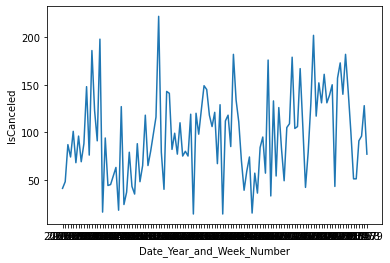

In [22]:
sns.lineplot(data=df, x="Date_Year_and_Week_Number", y="IsCanceled")

## 1. Decomposition of the time series and plots of the trend, residual, and seasonal components

## Additive Model

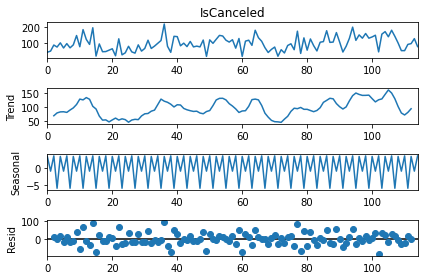

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(df['IsCanceled'],model = 'add',period=4)
result_add.plot();

In [24]:
print(type(result_add.resid))

<class 'pandas.core.series.Series'>


In [38]:
result_add.trend.describe()

count    111.000000
mean      97.472973
std       28.229047
min       46.750000
25%       79.687500
50%       94.750000
75%      123.500000
max      161.250000
Name: trend, dtype: float64

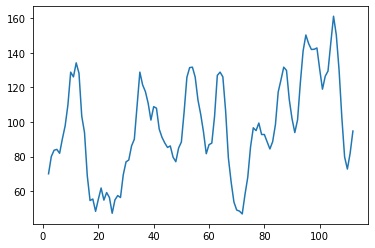

In [39]:
result_add.trend.plot()

## Hard to tell if there is a trend to the data

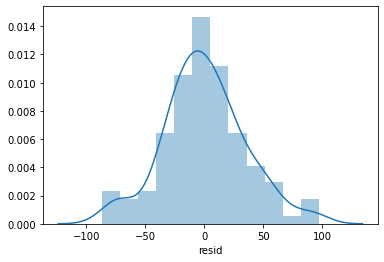

In [25]:
sns.distplot(result_add.resid)

## Multiplicative Model

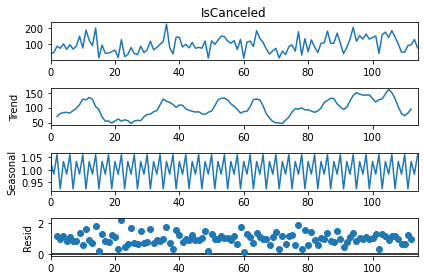

In [26]:
result_mul = seasonal_decompose(df['IsCanceled'],model = 'mul',period=4)
result_mul.plot();

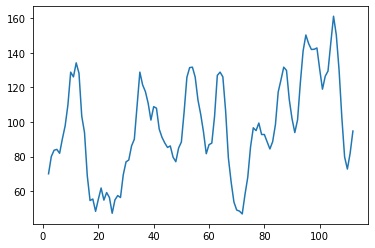

In [40]:
result_mul.trend.plot()

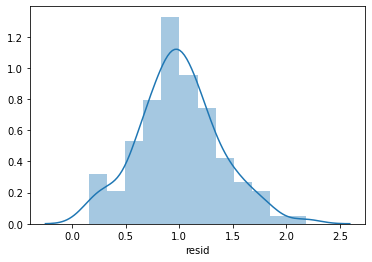

In [27]:
sns.distplot(result_mul.resid)

## 2. Autocorrelation and partial autocorrelation plots of the time series

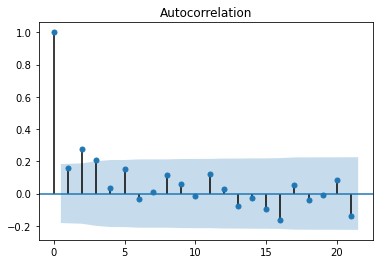

In [28]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df['IsCanceled'])
#pyplot.show()
plt.show()

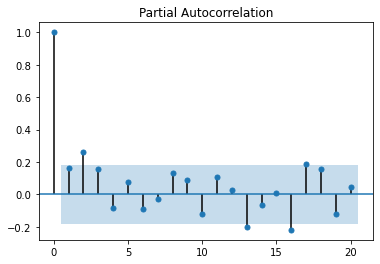

In [29]:
#from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df['IsCanceled'], lags=20)
plt.show()

## 3. A 4-period SMA plotted against the actual time series

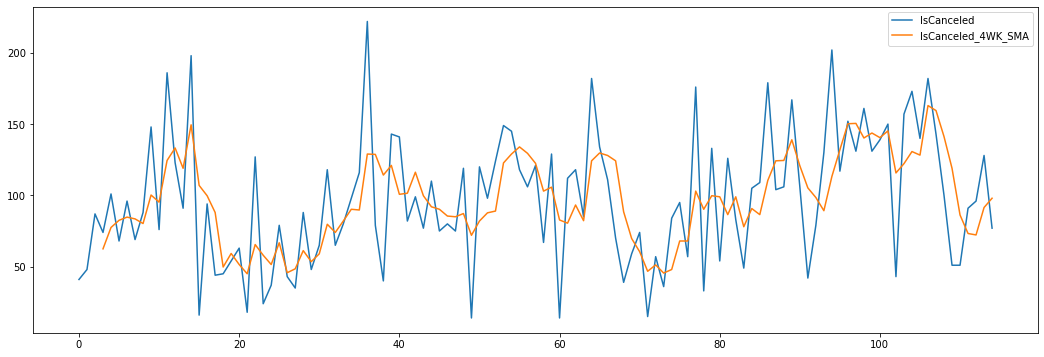

In [30]:
df['IsCanceled_4WK_SMA'] = df['IsCanceled'].rolling(window=4).mean()
df[['IsCanceled','IsCanceled_4WK_SMA']].plot(figsize=(18,6))

## 4. A 90/10 train-test split

In [31]:
df['IsCanceled'].size

115

In [32]:
test_size = 12
train_size = df['IsCanceled'].size - test_size
data_train = df['IsCanceled'].iloc[0:train_size]
data_test = df['IsCanceled'].iloc[train_size:]

In [33]:
print(train_size)

103


In [34]:
print(type(data_train))

<class 'pandas.core.series.Series'>


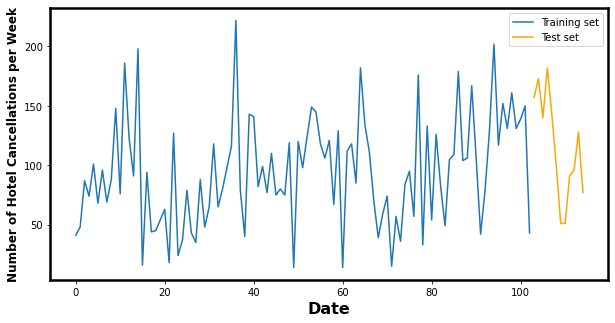

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)    
    
plt.plot(data_train, label='Training set')
plt.plot(data_test, label='Test set', color='orange')
plt.xlabel('Date',fontsize=16,fontweight='bold')
plt.ylabel('Number of Hotel Cancellations per Week', fontsize=12,fontweight='bold')
plt.legend();

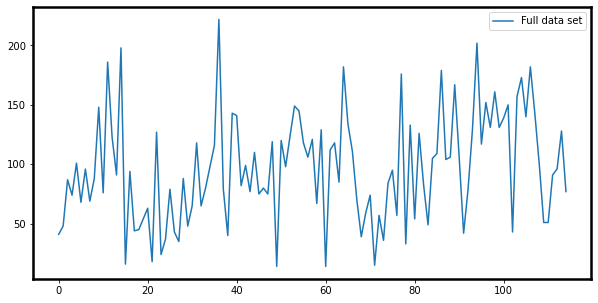

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)    
    
plt.plot(df['IsCanceled'], label='Full data set')
plt.legend();